In [111]:
import numpy as np
import os
from CoPhaser import utils
from CoPhaser import plotting
from CoPhaser import gene_sets
import sys

sys.path.insert(0, "../set_up")  # add set_up path to search list

import plot_helpers
import constants

from scipy.stats import pearsonr
from scipy.sparse import csr_matrix, hstack, vstack

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

import anndata
import scanpy as sc
import pickle
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [112]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
DATA_FOLDER = "../figure_4/data/"

height_ratios_scaling: [1, 1, 1]


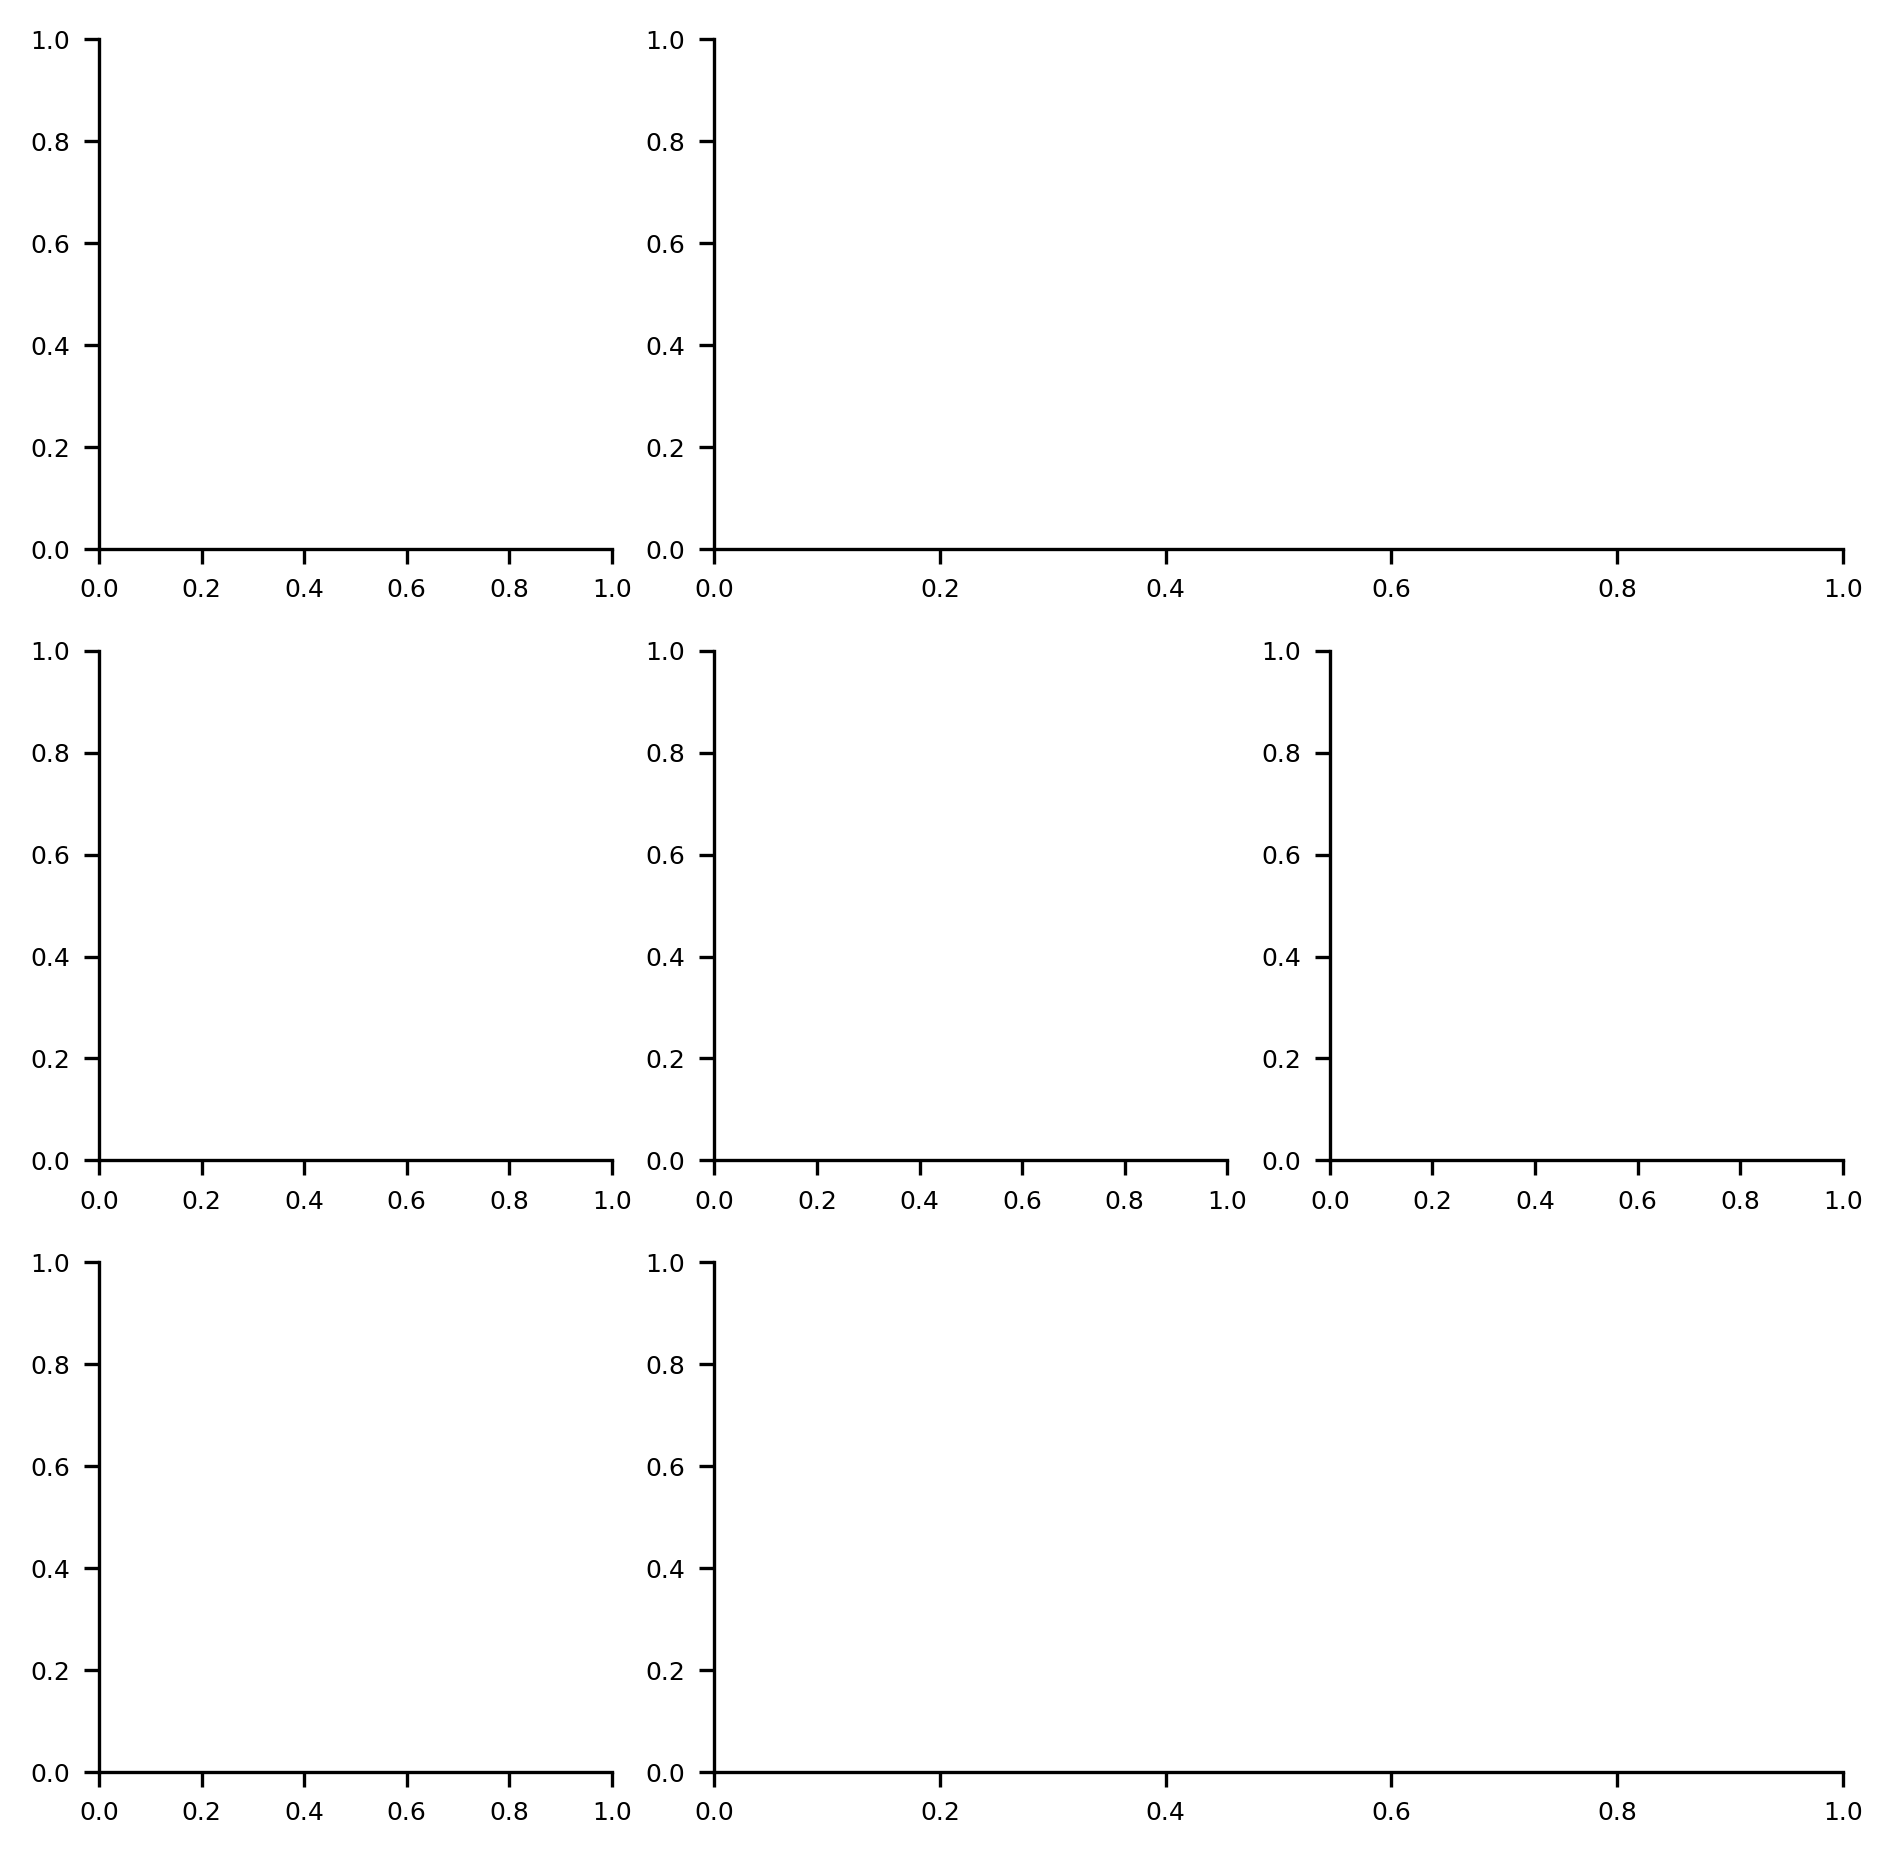

In [114]:
mosaic = [["A", "B", "B"], ["C", "D", "E"], ["F", "G", "G"]]
fig, axs = plot_helpers.create_pannels(mosaic=mosaic, h_pad=0)

In [115]:
skin = pickle.load(open(os.path.join(DATA_FOLDER, "aorta_results.pkl"), "rb"))

In [116]:
def optimal_shift(p, p0, n_s=100):
    """
    Aligns two sequences defined on the unit circle, taking care of the periodicity
    and the flipping symmetry of the circle.
    It uses the median absolute deviation (MAD) as a measure of the distance between the two sequences.

    Parameters:
    p: phase array to adjust
    p0: phase array (reference)
    n_s: number of shifts to consider

    Returns:
    phi_aligned: the aligned phase array
    best_mad: the MAD of the best alignment
    """

    def circular_deviation2(x, y, period=2 * np.pi):
        """
        Function called by optimal_shift
        Inputs:
        x: phase array
        y: phase array
        period: period of the circular variable
        """
        x, y = x % period, y % period
        v1 = np.abs(x - y)
        v2 = (period - v1) % period

        return np.minimum(v1, v2)

    Nc = p.shape[0]
    shifts = np.linspace(0, 2 * np.pi, n_s)
    # creating a matrix of all possible shifts
    theta_cs = (p.reshape(Nc, 1) - shifts.reshape(1, n_s)) % (2 * np.pi)
    theta_cs_neg = (-p.reshape(Nc, 1) - shifts.reshape(1, n_s)) % (2 * np.pi)

    # for each shift, computing the circular deviation, using apply_along_axis
    delta_cs = circular_deviation2(p0[:, None], theta_cs)
    delta_cs_neg = circular_deviation2(p0[:, None], theta_cs_neg)

    # computing the median absolute deviation for all shifts
    v = np.median(delta_cs, axis=0)
    v_neg = np.median(delta_cs_neg, axis=0)
    # selecting the best shift
    best_shift_ind = np.argmin(v)
    best_shift_ind_neg = np.argmin(v_neg)
    mad, mad_neg = v[best_shift_ind], v_neg[best_shift_ind_neg]

    # selecting which direction is the best
    if mad < mad_neg:
        phi_aligned = theta_cs[:, best_shift_ind]
        best_mad = mad
    else:
        phi_aligned = theta_cs_neg[:, best_shift_ind_neg]
        best_mad = mad_neg

    return phi_aligned, best_mad


def get_MAD(adata, thetas):
    w = 2 * np.pi / 24
    true_phase = (adata.obs.zt.values % 24) * w
    if not isinstance(thetas, np.ndarray):
        thetas = thetas.detach().numpy()
    phi = thetas % (2 * np.pi)

    _, mad = optimal_shift(phi, true_phase)
    return mad / w


def get_gene_fractions(gene_name, adata, layer="total"):
    library_size = adata.layers[layer].sum(axis=1)
    library_size = np.array(library_size).flatten()
    gene_fractions = (
        adata[:, gene_name].layers[layer].toarray().flatten() / library_size
    )
    return gene_fractions


def get_genes_fractions(gene_names, adata, layer="total"):
    library_size = adata.layers[layer].sum(axis=1)
    library_size = np.array(library_size).flatten()
    gene_fractions = (adata[:, gene_names].layers[layer].toarray().T / library_size).T
    return gene_fractions


def plot_gene_profiles(
    gene_names,
    adata,
    inferred_phase,
    axs,
    position,
    GT_phase=None,
    layer="total",
    hue=None,
    phase_label="Inferred",
    legend_title=None,
):
    try:
        axs = plot_helpers.replace_mosaic_cell_with_grid(
            fig, axs, label=position, nrows=1, ncols=len(gene_names)
        )
    except:
        pass
    if hue is not None:
        # drop hue with less than 100 samples
        counts = adata.obs[hue].value_counts()
        valid_hues = counts[counts >= 100].index
        valid_indices = adata.obs[hue].values.isin(valid_hues)
        adata = adata[valid_indices]
        hue = adata.obs[hue].values
        inferred_phase = inferred_phase[valid_indices]
    for i in range(len(gene_names)):
        gene_name = gene_names[i]
        gene_fractions = get_gene_fractions(gene_name, adata, layer=layer)
        axs[position][i] = modify_xlabels(
            axs[position][i], add_endpoint=True, n_xticks=4
        )

        plotting.plot_smoothed_profiles(
            inferred_phase,
            np.log(gene_fractions * 1e4 + 1),
            ax=axs[position][i],
            nbins=20,
            xlabel="Inferred Phase",
            ylabel=f"Normalized Counts (log)" if i == 0 else None,
            title=f"{gene_name} Profile",
            label=(
                phase_label
                if (i == len(gene_names) - 1 and GT_phase is not None)
                else None
            ),
            legend=i == len(gene_names) - 1,
            hue=hue,
        )
        if i == len(gene_names) - 1 and legend_title is not None:
            axs[position][i].legend(title=legend_title)


def modify_xlabels(ax, n_xticks=8, add_endpoint=False):
    if add_endpoint:
        n_xticks += 1
    ticks = np.linspace(0, 2 * np.pi, n_xticks, endpoint=add_endpoint)
    ax.set_xticks(ticks)
    ax.set_xticklabels([f"{int(tick / (2 * np.pi) * 24)}h" for tick in ticks])
    return ax


def shift_polar_plot(ax, inner_ring_size=0, n_xticks=8):

    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)

    # Shift the radial axis upward so that plotting at r=0 actually
    # starts at r = inner_ring_size
    if inner_ring_size < 0:
        ax.set_rorigin(inner_ring_size)

    # Standard formatting
    ax.set_rlabel_position(0)
    ax = modify_xlabels(ax, n_xticks=n_xticks)
    # remove y ticks
    ax.set_yticks([])

    return ax

In [117]:
adata = skin["adata"]
phase_aligned = skin["phase_aligned"]

In [118]:
cycling_genes = gene_sets.SMALL_CIRCADIAN_GENE_SET
cycling_genes = [g for g in cycling_genes if g in adata.var_names]
df_to_plot = {
    "Mean Circadian Fractions": [],
    "Status": [],
    "Cell Type": [],
}
for ct in sorted(adata.obs["celltype"].unique().tolist()):
    indices = adata.obs["celltype"] == ct
    library_size = adata.layers["total"].sum(axis=1)
    library_size = np.array(library_size).flatten()[indices]
    mean_counts_pred = (
        skin["df_mean"][indices.values]
        .loc[:, cycling_genes]
        .div(library_size, axis=0)
        .sum(axis=1)
        .mean()
    )
    mean_counts_obs = (
        get_genes_fractions(
            cycling_genes,
            adata[indices],
        )
        .sum(axis=1)
        .mean()
    )
    df_to_plot["Mean Circadian Fractions"].append(mean_counts_obs)
    df_to_plot["Status"].append("Observed")
    df_to_plot["Cell Type"].append(ct)
    df_to_plot["Mean Circadian Fractions"].append(mean_counts_pred)
    df_to_plot["Status"].append("Predicted")
    df_to_plot["Cell Type"].append(ct)
df_to_plot = pd.DataFrame(df_to_plot)
ax = axs["A"]
# sort from higher to lower
df_to_plot = df_to_plot.sort_values(by="Mean Circadian Fractions", ascending=False)
df_to_plot["Cell Type"] = df_to_plot["Cell Type"].replace("macrophage", "\nmacrophage")
df_to_plot["Cell Type"] = df_to_plot["Cell Type"].replace(
    "endothelial", "\nendothelial"
)
sns.barplot(
    data=df_to_plot,
    x="Cell Type",
    y="Mean Circadian Fractions",
    hue="Status",
    ax=ax,
    palette="Set2",
)
ax.set_title("Circadian Gene Fractions")
ax.legend(title="")

In [119]:
def plot_gene_fractions_pseudobulk(
    adata, genes, axs, position, hue="celltype", hue_label="Cell Type", hue_order=None
):
    try:
        axs = plot_helpers.replace_mosaic_cell_with_grid(
            fig, axs, label=position, nrows=1, ncols=len(genes)
        )
    except:
        pass
    df_to_plot = {
        "zt": adata.obs.zt.values,
        hue_label: adata.obs[hue].values,
    }
    for gene in genes:
        df_to_plot[gene] = np.log1p(
            get_gene_fractions(gene, adata, layer="total") * 1e4
        )
    df_to_plot = pd.DataFrame(df_to_plot)
    for i, gene in enumerate(genes):
        ax = axs[position][i]
        sns.barplot(
            data=df_to_plot,
            y=gene,
            x="zt",
            ax=ax,
            hue=hue_label,
            legend=i == len(genes) - 1,
            # reduce error bars width
            err_kws={"linewidth": 1},
            hue_order=hue_order,
        )
        ax.set_title(f"{gene} Pseudobulk")
        if i == 0:
            ax.set_ylabel("Normalized counts (log)")
        else:
            ax.set_ylabel("")


plot_gene_fractions_pseudobulk(
    adata, genes=["Nfil3", "Hlf", "Npas2"], axs=axs, position="B"
)

In [120]:
skin["lambda"].flatten()

array([0.85173786, 1.0106148 , 0.76666844, ..., 1.1320231 , 1.0773195 ,
       1.1052476 ], dtype=float32)

In [121]:
df_to_plot = {
    "Cell Type": adata.obs.celltype.values,
    "λ": 2 ** (skin["lambda"].flatten() - 1),
}
df_to_plot = pd.DataFrame(df_to_plot)
# sort from higher to lower
cell_type_order = (
    df_to_plot.groupby("Cell Type")["λ"].mean().sort_values(ascending=False).index
)
# add \n for even indexes
x_labels = []
for i, ct in enumerate(cell_type_order):
    if i % 2 == 1:
        x_labels.append("\n" + ct)
    else:
        x_labels.append(ct)
# map cell type to colors by alphabetical order
cell_type_colors = {
    ct: cm.tab10(i)
    for i, ct in enumerate(sorted(adata.obs["celltype"].unique().tolist()))
}
ax = axs["C"]
sns.barplot(
    data=df_to_plot,
    x="Cell Type",
    y="λ",
    ax=ax,
    palette=cell_type_colors,
    order=cell_type_order,
)
ax.set_title("Mean Inferred λ")
ax.set_ylabel("λ")
ax.set_xticklabels(x_labels)

/tmp/ipykernel_1475026/1588084925.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_to_plot.groupby("Cell Type")["λ"].mean().sort_values(ascending=False).index
/tmp/ipykernel_1475026/1588084925.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_1475026/1588084925.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


[Text(0, 0, 'smc'),
 Text(1, 0, '\nfibroblast'),
 Text(2, 0, 'macrophage'),
 Text(3, 0, '\nendothelial')]

In [124]:
adata.obs["leiden_names"] = adata.obs["leiden"].copy()
adata.obs["leiden_names"] = adata.obs["leiden_names"].map(
    {"0": "med", "1": "low", "2": "high"}
)

In [125]:
valid_indices = adata.obs["leiden_names"].isin(["med", "low", "high"])
ax = axs["D"]
sns.scatterplot(
    x=skin["z"][valid_indices, 0],
    y=skin["z"][valid_indices, 1],
    hue=adata.obs["leiden_names"][valid_indices].astype(str),
    s=5,
    ax=ax,
    edgecolor="none",
    hue_order=["low", "med", "high"],
)
# remove x,y tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Leiden Clusters")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.legend(title="Rgs5")

/home/maxine/miniconda3/envs/VAE_Fourrier_Env/lib/python3.12/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


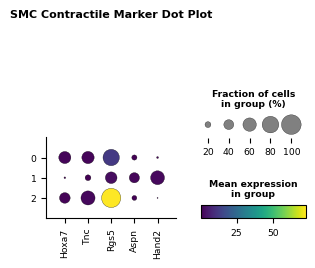

In [126]:
markers_descending_aorta = ["Hoxa7", "Tnc"]
markers_aortic_arch_acending = ["Aspn", "Hand2"]
smc_markers = markers_descending_aorta + ["Rgs5"] + markers_aortic_arch_acending

sc.pl.dotplot(
    adata[valid_indices],
    var_names=smc_markers,
    groupby="leiden",
    color_map="viridis",
    title="SMC Contractile Marker Dot Plot",
    show=True,
)

In [127]:
import pandas as pd
import numpy as np

adata_sub = adata[valid_indices]

groups = adata_sub.obs["leiden_names"].unique()
genes = smc_markers

rows = []

for group in groups:
    cells = adata_sub.obs["leiden_names"] == group
    X = adata_sub[cells, genes].X

    if not isinstance(X, np.ndarray):
        X = X.toarray()

    mean_expr = X.mean(axis=0)
    pct_expr = (X > 0).mean(axis=0)

    for g, m, p in zip(genes, mean_expr, pct_expr):
        rows.append({"leiden_names": group, "gene": g, "mean_expr": m, "pct_expr": p})

df = pd.DataFrame(rows)

In [128]:
ax = axs["E"]
# Main plot (80%)
ax_plot = inset_axes(
    ax,
    width="80%",
    height="100%",
    loc="lower left",
    bbox_to_anchor=(0, 0, 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)

# Legend panel (20%)
ax_leg = inset_axes(
    ax,
    width="20%",
    height="100%",
    loc="lower right",
    bbox_to_anchor=(0, 0, 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)
# sort df by ["low","med","high"]
df["leiden_names"] = pd.Categorical(
    df["leiden_names"], categories=["low", "med", "high"], ordered=True
)
df = df.sort_values("leiden_names", ascending=False)
sns.scatterplot(
    data=df,
    x="gene",
    y="leiden_names",
    size="pct_expr",
    hue="mean_expr",
    palette="viridis",
    sizes=(5, 80),
    linewidth=0,
    legend=False,
    ax=ax_plot,
)
ax_plot.set_ylim(-0.5, 2.5)
ax_plot.set_xlim(-0.5, len(smc_markers))
ax_plot.set_title("SMC markers", fontsize=8, pad=4)
ax_plot.set_xlabel("")
ax_plot.set_ylabel("")
ax_plot.tick_params(axis="x", labelrotation=90, labelsize=6)
ax_plot.tick_params(axis="y", labelsize=6)
vmin, vmax = df.mean_expr.min(), df.mean_expr.max()
cmap = mpl.cm.get_cmap("viridis")
norm = mpl.colors.Normalize(vmin, vmax)

color_vals = np.linspace(vmin, vmax, 3)

color_handles = [
    mpl.lines.Line2D(
        [],
        [],
        linestyle="",
        marker="o",
        markersize=4,
        markerfacecolor=cmap(norm(v)),
        markeredgecolor="none",
        label=f"{v:.1f}",
    )
    for v in color_vals
]

leg1 = ax_leg.legend(
    handles=color_handles,
    title="Mean expr",
    title_fontsize=6,
    fontsize=6,
    frameon=False,
    loc="center",
    borderpad=0.2,
    handletextpad=0.3,
)
ax_leg.add_artist(leg1)
size_vals = [0.1, 0.5, 0.9]  # representative % expressing
size_vals = [v for v in size_vals if v <= df.pct_expr.max()]

size_min, size_max = 5, 80


def size_map(v):
    return size_min + v * (size_max - size_min)


size_handles = [
    mpl.lines.Line2D(
        [],
        [],
        linestyle="",
        marker="o",
        markersize=np.sqrt(size_map(v)),  # matplotlib marker size is area-based
        markerfacecolor="gray",
        markeredgecolor="none",
        label=f"{int(v*100)}%",
    )
    for v in size_vals
]

ax_leg.legend(
    handles=size_handles,
    title="% expr",
    title_fontsize=6,
    fontsize=6,
    frameon=False,
    loc="lower center",
    borderpad=0.2,
    handletextpad=0.3,
)

ax_leg.axis("off")
ax.axis("off")

/tmp/ipykernel_1475026/3966305839.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("viridis")


(0.0, 1.0, 0.0, 1.0)

In [129]:
# clock genes
cycling_genes = list(gene_sets.SMALL_CIRCADIAN_GENE_SET) + ["Hlf", "Nfil3", "Nampt"]
cycling_genes.remove("Arntl")
df_to_plot = skin["df_z"][cycling_genes].copy()
df_to_plot["leiden_names"] = adata.obs["leiden_names"].values
df_to_plot = df_to_plot[df_to_plot["leiden_names"].isin(["med", "low", "high"])]
df_to_plot = df_to_plot.groupby("leiden_names").mean()
df_to_plot = df_to_plot.T
# remove mean
df_to_plot = df_to_plot.sub(df_to_plot.mean(axis=1), axis=0)
# sort by variance
df_to_plot = df_to_plot.loc[df_to_plot.var(axis=1).sort_values(ascending=False).index]
# sort columns in order low, med, high
df_to_plot = df_to_plot[["low", "med", "high"]]
ax = axs["F"]
sns.heatmap(
    df_to_plot,
    cmap="magma",
    cbar_kws={"label": "Mean Δμ"},
    yticklabels=True,
    xticklabels=True,
    ax=ax,
)
# rotate x labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title("Predicted Δμ")

Text(0.5, 1.0, 'Predicted Δμ')

In [130]:
plot_gene_fractions_pseudobulk(
    adata[adata.obs["leiden"].isin(["0", "1", "2"])],
    ["Per1", "Nampt", "Nfil3"],
    axs,
    "G",
    hue="leiden_names",
    hue_label="Rgs5",
    hue_order=["low", "med", "high"],
)

/home/maxine/Documents/paychere/cell_cycle_VAE_Fourrier_model/paper/code/figure_S8/../set_up/plot_helpers.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  figure.tight_layout()


Figure saved to: /home/maxine/Documents/paychere/cell_cycle_VAE_Fourrier_model/paper/figures/figure_S8_circadian_python.svg


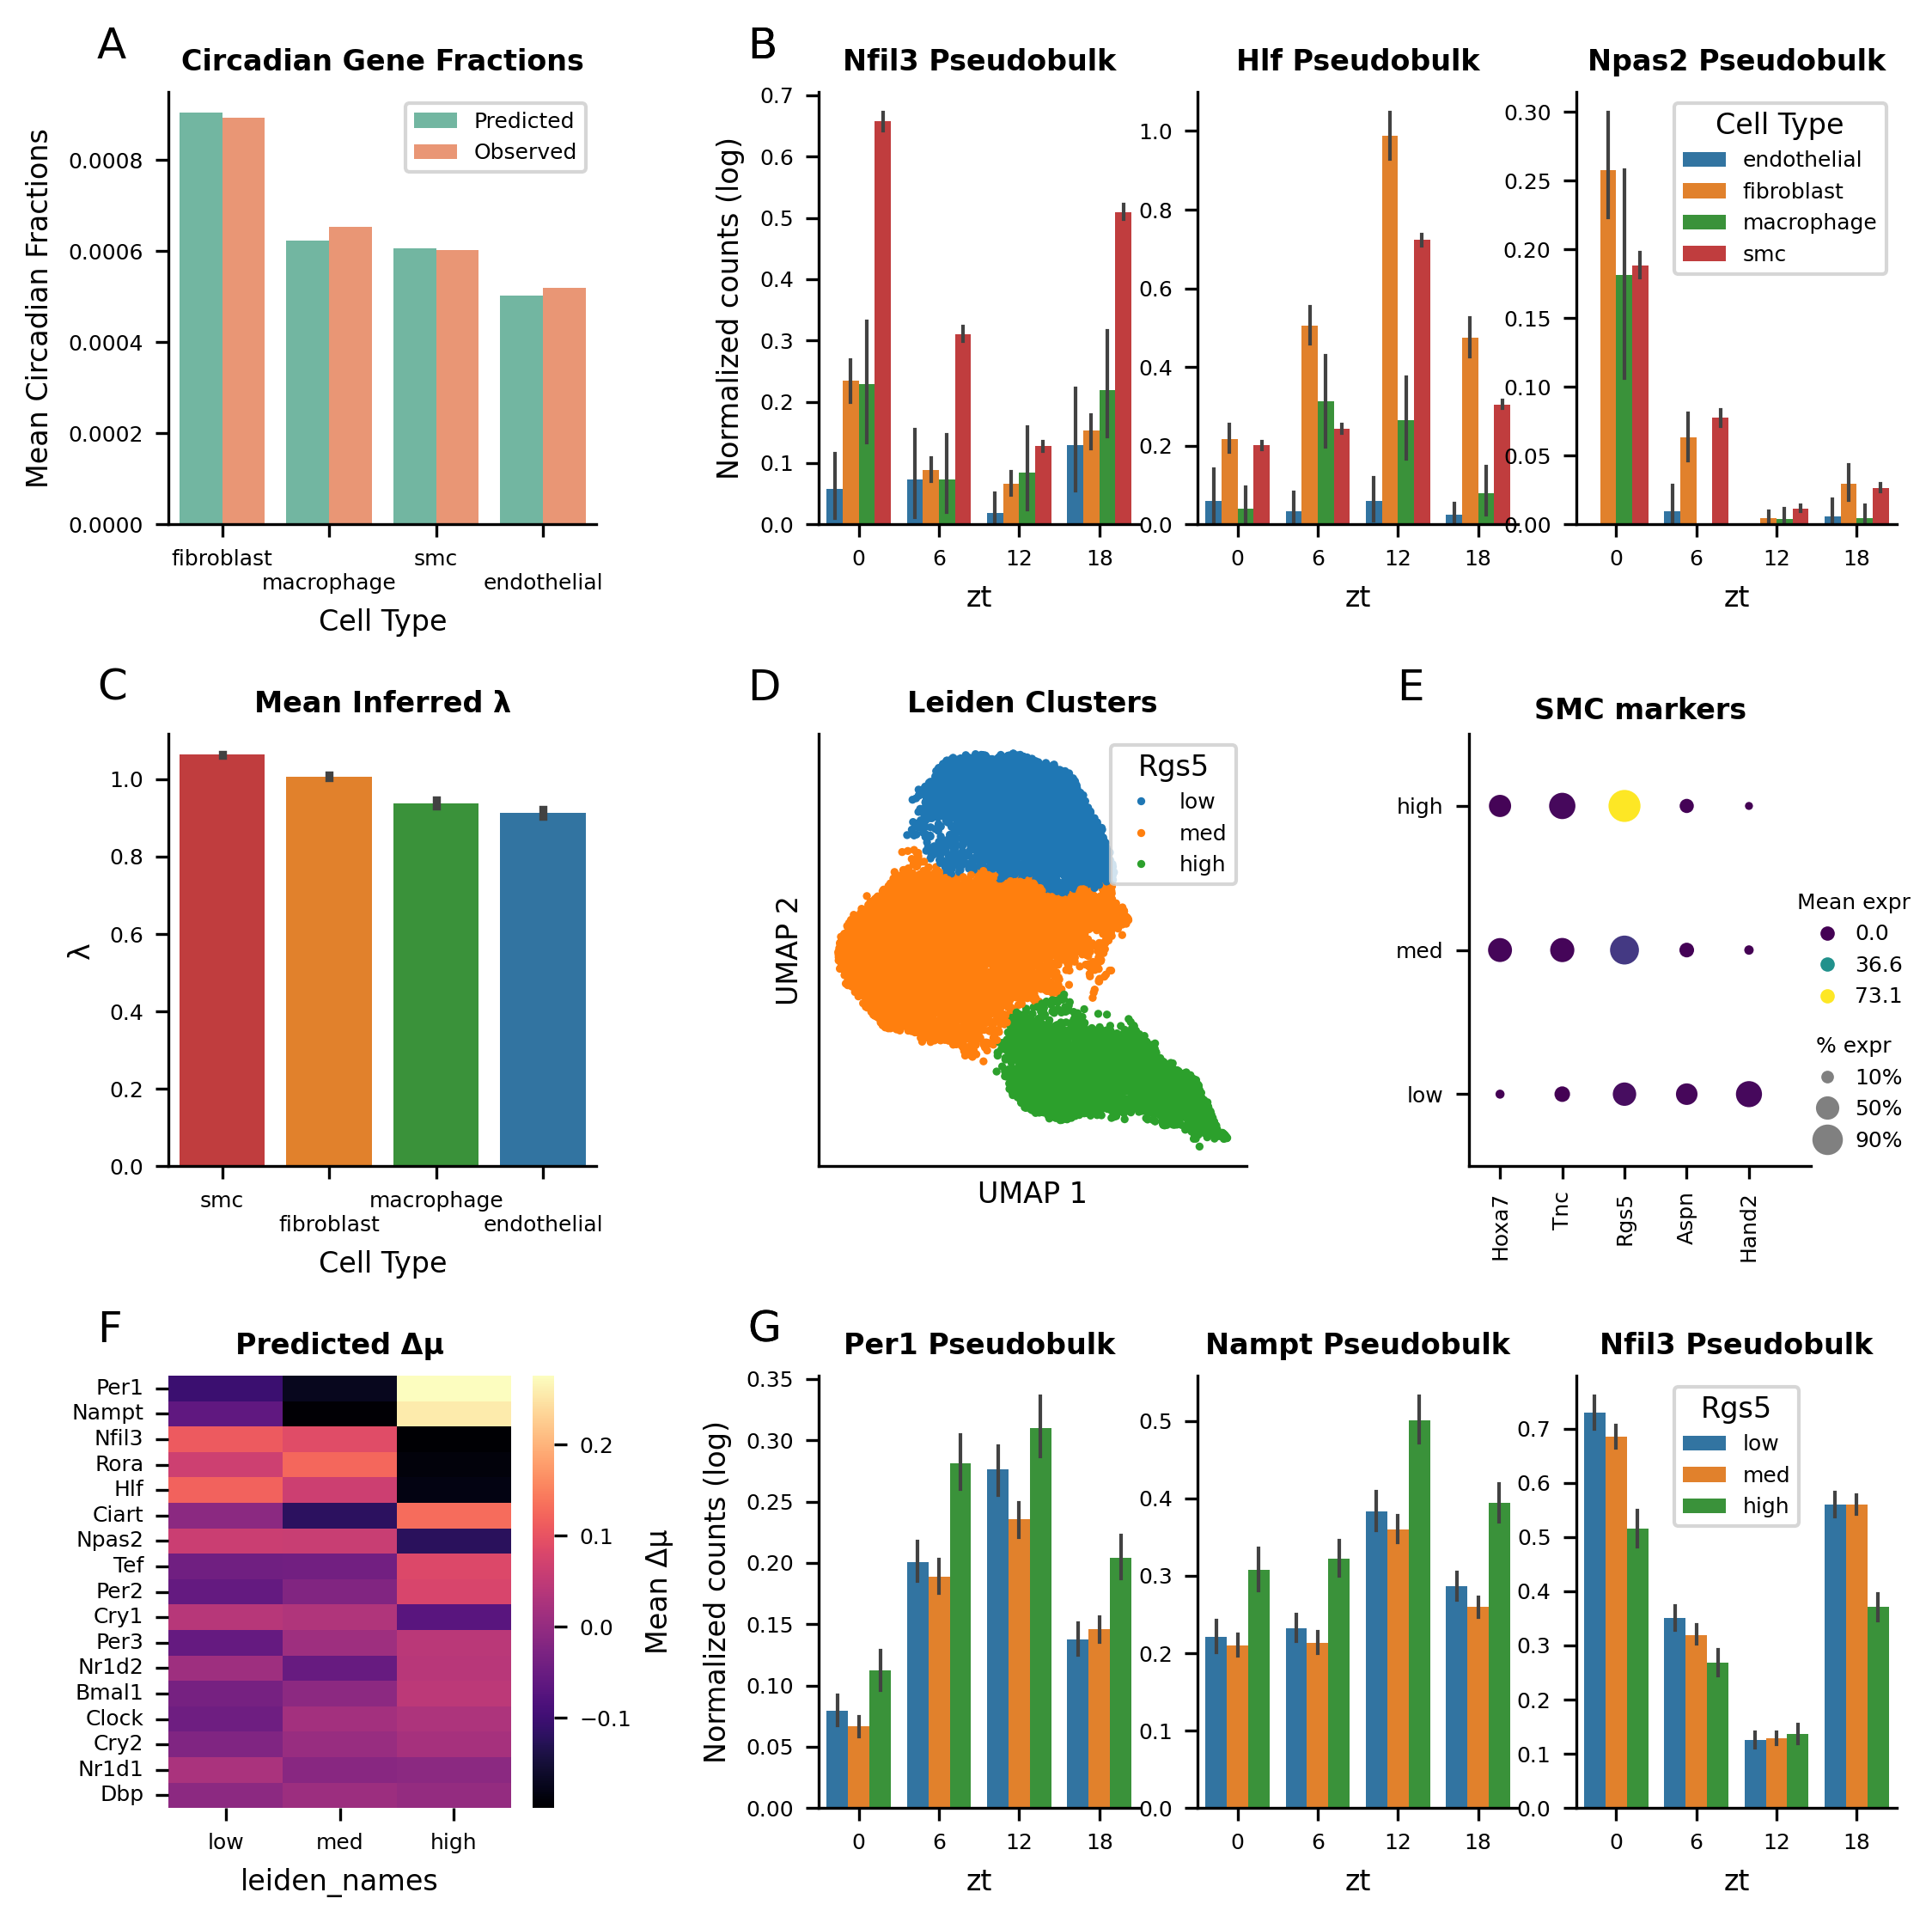

In [131]:
plot_helpers.label_panels_mosaic(fig, axs, mosaic)
plot_helpers.save_figure(fig, axs, "figure_S8_circadian_python")